# Machine-Assisted Intent Labeling

You don't yet know the "intent" of all the user utterances in your dataset, but you do not want to have to read and label them all.
The goal is to train a model that can label human utterances with close to 100% test-set accuracy.
with a supervised learning model with a human having read and analyzed as few samples of your dataset as possible.

1. label some portion of your data (label the rest "unknown")
2. train a classifier to classify your data
3. label all the data with your classifier
4. cluster the labeled and "unknown" data with a guess at K
5. assign labels to clusters based on the true label (previously labeled by human) for each cluster
6. measure the accuracy (purity of the clusters other than "unkown")
7. repeat 4-6 several times with new K values and choose the best (highest accuracy) clusters.
8. calculate the total accuracy and number of remaining unkown samples
9. repeat 1-8 several times, creating new labels from some unkowns, and moving some unkowns to a known label

## UX

The UX is the key. Because the human is in the loop, the ML must assist them and guide them in adding new labels or creating new labels. It should not provide too much information nor too little in order to maximize the efficiency of the labler. The goal is to achieve close to 100% test-set accuracy with a supervised learning model with a human having read and analyzed as few samples of your dataset as possible.



In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import json

# change the default number of cols to be displayed
pd.options.display.max_columns = 1000

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

sns.set_style('white')
sns.set_theme('notebook')

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

In [41]:
from collections import Counter
from sklearn.metrics import confusion_matrix, f1_score

import pickle

In [5]:
EXPERIMENTS = []
ENCODER = 'sbert'

DATA_DIR = Path('.') / 'data'
FILEPATH = DATA_DIR / 'utterance_intent_pairs_revised.csv'
# FILEPATH = DATA_DIR / 'utterance_intent_pairs_augmented.csv'
# FILEPATH = DATA_DIR / 'augumented_utterance_intent_pairs.csv'
MIN_EXAMPLES = 4  # minimum number of example utterance per intent (class label), user will be asked to supply paraphrases

In [6]:
df = pd.read_csv(FILEPATH)
df =  df[['utterance', 'intent']].copy()
df['intent'] = df['intent'].str.lower().str.strip().str.replace(' ', '_').str.replace('-', '_')
print(df.shape)
utterances = list(df['utterance'].fillna('')) # replace the NULL values with empty value
intents = list(df['intent'].copy().fillna('unknown')) # replace the NULL values with unknown value
counts = pd.Series(Counter(intents)).sort_values() # creates a frequency table of intents
counts

(1094, 2)


watched_videos                4
how_are_you                   4
both_languages                4
restart                       4
insurance_for_work            6
quiz_module                   6
addressing_maya               7
testing_you                   7
other_languages               7
what_is_unsafe_migration      8
how_to_get_involved           8
main_menu                     8
stories_module                8
ask_question                  9
scary_or_terrible            10
no                           10
stupid_bot                   10
documents_needed             11
yes                          16
continue                     16
safe_behaviors               16
information                  16
i_love_you                   17
online_safety                18
where_are_you_from           21
what_is_trafficking          23
change_language              28
thank_you                    30
emergency                    33
goodbye                      35
who_are_you_maya             36
hello   

In [7]:
counts_dict = counts.to_dict() # convert the frequency table to a dict
counts_dict

{'watched_videos': 4,
 'how_are_you': 4,
 'both_languages': 4,
 'restart': 4,
 'insurance_for_work': 6,
 'quiz_module': 6,
 'addressing_maya': 7,
 'testing_you': 7,
 'other_languages': 7,
 'what_is_unsafe_migration': 8,
 'how_to_get_involved': 8,
 'main_menu': 8,
 'stories_module': 8,
 'ask_question': 9,
 'scary_or_terrible': 10,
 'no': 10,
 'stupid_bot': 10,
 'documents_needed': 11,
 'yes': 16,
 'continue': 16,
 'safe_behaviors': 16,
 'information': 16,
 'i_love_you': 17,
 'online_safety': 18,
 'where_are_you_from': 21,
 'what_is_trafficking': 23,
 'change_language': 28,
 'thank_you': 30,
 'emergency': 33,
 'goodbye': 35,
 'who_are_you_maya': 36,
 'hello': 72,
 'ok': 90,
 'unknown': 496}

In [8]:
new_utterances = []
new_intents = []

for label in counts_dict:
    print('='*10, label, '='*10)
    while counts_dict[label] < MIN_EXAMPLES:
        sep = '\n    '
        print(f'Input a new utterance for "{ label }". Examples: { sep }')
        print(sep.join(df['utterance'][df['intent'] == label]))
        utt = input('YOUR NEW UTTERANCE: ')
        new_utterances.append(utt)
        new_intents.append(label)
        counts_dict[label] += 1
        
intents += new_intents
utterances += new_utterances

========== watched_videos ==========
========== how_are_you ==========
========== both_languages ==========
========== restart ==========
========== insurance_for_work ==========
========== quiz_module ==========
========== addressing_maya ==========
========== testing_you ==========
========== other_languages ==========
========== what_is_unsafe_migration ==========
========== how_to_get_involved ==========
========== main_menu ==========
========== stories_module ==========
========== ask_question ==========
========== scary_or_terrible ==========
========== no ==========
========== stupid_bot ==========
========== documents_needed ==========
========== yes ==========
========== continue ==========
========== safe_behaviors ==========
========== information ==========
========== i_love_you ==========
========== online_safety ==========
========== where_are_you_from ==========
========== what_is_trafficking ==========
========== change_language ==========
========== thank_you ========

In [9]:
FILEPATH

PosixPath('data/utterance_intent_pairs_revised.csv')

In [10]:
df = pd.DataFrame({'utterance': utterances, 'intent': intents})
df.to_csv(FILEPATH.with_suffix('.augmented.csv'), index=False) # data augmentation
df

utterance               intent
0                                              "*menu*"            main_menu
1                                         ", thank you"            thank_you
2                              "1. What is trafficking"  what_is_trafficking
3                                 "2. Safety behaviors"       safe_behaviors
4     "A question the system is not supposed to reco...          testing_you
...                                                 ...                  ...
1089                             Tell me more about it.          information
1090                               nepalese and english       both_languages
1091                     I'd like to ask you something.         ask_question
1092                                  How was your day?          how_are_you
1093                                    tell me a story       stories_module

[1094 rows x 2 columns]

In [11]:
sorted(df['intent'].unique())

['addressing_maya',
 'ask_question',
 'both_languages',
 'change_language',
 'continue',
 'documents_needed',
 'emergency',
 'goodbye',
 'hello',
 'how_are_you',
 'how_to_get_involved',
 'i_love_you',
 'information',
 'insurance_for_work',
 'main_menu',
 'no',
 'ok',
 'online_safety',
 'other_languages',
 'quiz_module',
 'restart',
 'safe_behaviors',
 'scary_or_terrible',
 'stories_module',
 'stupid_bot',
 'testing_you',
 'thank_you',
 'unknown',
 'watched_videos',
 'what_is_trafficking',
 'what_is_unsafe_migration',
 'where_are_you_from',
 'who_are_you_maya',
 'yes']

In [12]:
if counts.sum() != len(df):
    ans = input(f"Would you like to overwrite the origin dataset ({counts.sum()}x2) with the new one ({df.shape[0]}x2)?")
    if ans and ans[0] in 'yY':
        df.to_csv(FILEPATH, index=False)
        print(f"Wrote dataset to '{FILEPATH}'")
    else:
        print(f"Retained new augmented dataset in '{FILEPATH.with_suffix('.augmented.csv')}'")

In [13]:
counts = pd.Series(Counter(intents)).sort_values()
counts

watched_videos                4
how_are_you                   4
both_languages                4
restart                       4
insurance_for_work            6
quiz_module                   6
addressing_maya               7
testing_you                   7
other_languages               7
what_is_unsafe_migration      8
how_to_get_involved           8
main_menu                     8
stories_module                8
ask_question                  9
scary_or_terrible            10
no                           10
stupid_bot                   10
documents_needed             11
yes                          16
continue                     16
safe_behaviors               16
information                  16
i_love_you                   17
online_safety                18
where_are_you_from           21
what_is_trafficking          23
change_language              28
thank_you                    30
emergency                    33
goodbye                      35
who_are_you_maya             36
hello   

In [14]:
intents[:20]

['main_menu',
 'thank_you',
 'what_is_trafficking',
 'safe_behaviors',
 'testing_you',
 'thank_you',
 'who_are_you_maya',
 'stupid_bot',
 'goodbye',
 'main_menu',
 'other_languages',
 'testing_you',
 'both_languages',
 'both_languages',
 'goodbye',
 'goodbye',
 'goodbye',
 'goodbye',
 'goodbye',
 'goodbye']

In [15]:
# Spacy is a library for advanced NLP, it contains pretrained pipelines and currently supports tokenization and training for 60+ languages.
# 'en_core_web_md' is an English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer.
# SentenceTransformers is a Python framework to compute sentence / text embeddings for more than 100 languages. 
# 'paraphrase-MiniLM-L6-v2' is a model that maps sentences & paragraphs to a 384 dimensional dense vector space.

In [16]:
if ENCODER == 'spacy':
    # https://spacy.io
    import spacy
    nlp = 'en_core_web_md'
    try:
        nlp = spacy.load(nlp)
    except OSError:
        spacy.cli.download(nlp)
    nlp = spacy.load(nlp) if isinstance(nlp, str) else nlp
    def encoder(s):
        return nlp(s).vector
elif ENCODER == 'sbert':
    # https://www.sbert.net/
    from sentence_transformers import SentenceTransformer
    sbert = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    def encoder(s):
        return sbert.encode(s)

In [17]:
X_sbert = pd.DataFrame([sbert.encode(s) for s in utterances])
Y_sbert = pd.DataFrame([sbert.encode(s) for s in intents])
print(X_sbert.shape)
print(Y_sbert.shape)

(1094, 384)
(1094, 384)


In [18]:
X_sbert

0         1         2         3         4         5         6    \
0    -0.192325  0.351547 -0.401720 -0.279345 -0.885547  0.162469  0.522297   
1    -0.208266  0.961237  0.875072 -0.281247  0.241235 -0.196954  0.889690   
2    -0.125743 -0.686314 -0.184287 -0.541811 -0.194062  0.102677  0.927314   
3     0.125855 -0.010347  0.034401 -0.269963 -0.102132 -0.132135  1.033633   
4    -0.045654 -0.041544 -0.470963  0.065244  0.142096 -0.197006  0.240167   
...        ...       ...       ...       ...       ...       ...       ...   
1089  0.435077  0.271822 -0.187940 -0.384736 -0.152571 -0.369107  0.207778   
1090 -0.057314  0.580661  0.037544 -0.188583 -0.244076 -0.261201  0.456308   
1091 -0.119237 -0.262714  0.322952 -0.156831  0.009182 -0.051252  0.394645   
1092  0.391092  0.640123  0.769632  0.164093 -0.101414 -0.605387  0.100637   
1093  0.309938  0.285759 -0.051677  0.011635 -0.208600 -0.127190  0.293726   

           7         8         9         10        11        12        13   \
0    -0.561957  0.246667 -0.038337 -0.379749 -0.195787 -0.166810 -0.301855   
1     0.021628  0.159962  0.316434 -0.205348 -0.618486 -0.342741 -0.106962   
2    -0.273768  0.074288  0.231915  0.248477 -0.216667  0.093060  0.207606   
3     0.043396 -0.133564  0.090605  0.518507  0.001983  0.409313 -0.030584   
4    -0.171028  0.384397  0.214496  0.327554  0.011322  0.153495 -0.062986   
...        ...       ...       ...       ...       ...       ...       ...   
1089  0.596570 -0.300117  0.045869 -0.151654 -0.251415 -0.193436  0.002770   
1090 -0.587077  0.523231  0.641451  0.405466 -0.547767  0.005708  0.105247   
1091 -0.143786 -0.023280  0.097482 -0.025657 -0.454262 -0.240470 -0.145935   
1092 -0.058457 -0.346393 -0.010803  0.138644  0.010788  0.040494  0.614740   
1093 -0.008818  0.088194  0.064727  0.088053 -0.494934 -0.145325  0.028061   

           14        15        16        17        18        19        20   \
0     0.124363 -0.118633  0.639000 -0.176973 -0.193239 -0.539214  0.142353   
1    -0.062488  0.109462  0.271735  0.126634 -0.525318 -0.455777  0.126160   
2     0.107917 -0.013324  0.470087  0.027483 -0.184138 -0.086041  0.038530   
3     0.305727  0.002469  0.671151  0.044960 -0.427156  0.088148 -0.018118   
4     0.184059 -0.066955  0.454694 -0.638669  0.221927  0.397256  0.257559   
...        ...       ...       ...       ...       ...       ...       ...   
1089  0.232134 -0.171400  0.534686 -0.439288 -0.508110  0.161419 -0.663345   
1090  0.234442  0.535132 -0.424676  0.006276 -0.685194 -0.389407  0.963766   
1091  0.586923  0.111921  0.296401  0.480405 -0.273265  0.005974 -0.081723   
1092  0.106940 -0.070517 -0.354921 -0.286637 -0.765654  0.105620 -0.622086   
1093  0.049957  0.069534  0.113533 -0.066773 -0.298139 -0.184175  0.050768   

           21        22        23        24        25        26        27   \
0    -0.047852 -0.663827  0.271669 -0.306885 -0.003171 -0.415152  0.065202   
1     0.101541  0.207779  0.118752 -0.101824  0.097404 -0.182901  0.321229   
2     0.002652 -0.274652 -0.107755 -0.439497 -0.257247 -0.157937  0.089212   
3    -0.414140  0.126358  0.054342 -0.653876  0.343940 -0.421456  0.294046   
4    -0.181031 -0.131756  0.115264 -0.471168  0.187604  0.108965  0.085378   
...        ...       ...       ...       ...       ...       ...       ...   
1089  0.414207  0.375590  0.352103  0.073577 -0.024284  0.141014  0.246825   
1090  0.111058  0.193580 -0.021124  0.648166  0.133131  0.397466 -0.345294   
1091  0.086036  0.240579  0.084527 -0.357888 -0.049280  0.271159  0.209264   
1092  0.180105 -0.584231  0.003043  0.368796  0.705128  0.505781  0.120378   
1093  0.130215  0.298911  0.090026  0.005709  0.355861  0.216219  0.299636   

           28        29        30        31        32        33        34   \
0    -0.130022 -0.258485  0.026755  0.387391  0.198926  0.067410  0.168287   
1     0.114753 -0.085421 -0.434111 -0.040087  0.451162 -0.109743 -0.062250   
2    -0.037354 -0.007215 -0.4

In [19]:
# word embeddding is a type of word reprentation that allows words with similar meanings have the same representation

In [19]:
utterances[7]

'"Are you stupid?"'

In [20]:
sbert.encode(utterances[7])

array([ 4.75171804e-01,  9.41395313e-02,  1.42093748e-01, -2.24785775e-01,
        7.56644011e-02, -8.52412820e-01,  7.14741588e-01,  3.58921170e-01,
        2.97494922e-02, -4.26860750e-01,  1.60008520e-01,  1.23845637e-02,
        1.99187040e-01,  2.60680884e-01,  1.16874501e-02, -1.32480487e-01,
       -2.40012661e-01, -4.76305902e-01, -5.63206196e-01,  4.98681188e-01,
       -2.37697884e-01, -4.28701378e-03,  3.10089570e-02,  2.19544858e-01,
        3.96260381e-01,  4.29618955e-01,  8.36884975e-02,  3.60113442e-01,
       -3.61465812e-01,  4.49907482e-01, -3.88142347e-01,  3.81023228e-01,
        3.90651494e-01,  5.63378483e-02,  6.31055772e-01,  2.57210284e-02,
        1.73175946e-01,  3.70707929e-01,  4.61373121e-01,  1.44333154e-01,
        3.44143249e-02, -7.33835280e-01, -3.21654021e-03, -3.71905953e-01,
        2.76583463e-01,  4.22233522e-01,  1.05341244e-02,  4.19832081e-01,
        1.86377540e-01, -2.52275884e-01, -3.71079743e-01, -1.00365058e-01,
       -1.25218123e-01, -

In [21]:
df

utterance               intent
0                                              "*menu*"            main_menu
1                                         ", thank you"            thank_you
2                              "1. What is trafficking"  what_is_trafficking
3                                 "2. Safety behaviors"       safe_behaviors
4     "A question the system is not supposed to reco...          testing_you
...                                                 ...                  ...
1089                             Tell me more about it.          information
1090                               nepalese and english       both_languages
1091                     I'd like to ask you something.         ask_question
1092                                  How was your day?          how_are_you
1093                                    tell me a story       stories_module

[1094 rows x 2 columns]

In [22]:
X = X_sbert.values 
y = intents 
# prints an unterrance and its corresponding intent
X[0].round(2), y[0]

(array([-0.19,  0.35, -0.4 , -0.28, -0.89,  0.16,  0.52, -0.56,  0.25,
        -0.04, -0.38, -0.2 , -0.17, -0.3 ,  0.12, -0.12,  0.64, -0.18,
        -0.19, -0.54,  0.14, -0.05, -0.66,  0.27, -0.31, -0.  , -0.42,
         0.07, -0.13, -0.26,  0.03,  0.39,  0.2 ,  0.07,  0.17,  0.53,
        -0.03, -0.07, -0.28, -0.56, -0.08,  0.01, -0.7 ,  0.1 ,  0.12,
        -0.92, -0.44, -0.18, -0.01,  0.34, -0.69,  0.29, -0.45, -0.36,
         0.33,  0.43, -0.06,  0.02,  0.07,  0.17, -0.33, -0.55, -0.16,
         0.65,  0.69,  0.24, -0.35,  0.01, -0.47,  0.81, -0.51, -0.29,
         0.2 ,  0.13,  0.62, -0.14,  0.01, -0.58, -0.54,  0.02,  0.19,
         0.13, -0.13, -0.13, -0.04,  0.29, -0.26, -0.48,  0.16, -0.39,
        -0.15, -0.58,  0.18,  0.45,  0.03, -0.35, -0.29, -0.61, -0.5 ,
         0.4 ,  0.32,  0.24,  1.06, -0.14,  0.04, -0.1 ,  0.21,  0.09,
        -0.53,  0.13, -0.3 ,  0.58,  0.59, -0.33, -0.9 , -0.55,  0.15,
        -0.2 ,  0.4 ,  0.18,  0.14,  0.35, -0.08,  0.26, -0.02,  0.17,
      

In [23]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)
# X_train.shape, len(y_train), X_test.shape, len(y_test)

In [24]:
X_train, X_test, y_train, y_test = X, X, y, y

In [25]:
# hyperparameter is a parameter that is set before the learning process begins to affect how well a model trains

In [26]:
hyperparams = dict(C=1, class_weight='balanced', random_state=1, max_iter=10000, multi_class='auto')
model = LogisticRegression(**hyperparams)
model.fit(X_train, y_train) # here, the model learns from the given data
model

LogisticRegression(C=1, class_weight='balanced', max_iter=10000, random_state=1)

In [27]:
model.classes_

array(['addressing_maya', 'ask_question', 'both_languages',
       'change_language', 'continue', 'documents_needed', 'emergency',
       'goodbye', 'hello', 'how_are_you', 'how_to_get_involved',
       'i_love_you', 'information', 'insurance_for_work', 'main_menu',
       'no', 'ok', 'online_safety', 'other_languages', 'quiz_module',
       'restart', 'safe_behaviors', 'scary_or_terrible', 'stories_module',
       'stupid_bot', 'testing_you', 'thank_you', 'unknown',
       'watched_videos', 'what_is_trafficking',
       'what_is_unsafe_migration', 'where_are_you_from',
       'who_are_you_maya', 'yes'], dtype='<U24')

In [28]:
# Make predictions on unseen data
y_test_pred = model.predict(X_test)
confusion_test = pd.DataFrame(
    confusion_matrix(
        y_test, y_test_pred, labels=model.classes_),
    index=model.classes_,
    columns=model.classes_)
confusion_test

addressing_maya  ask_question  both_languages  \
addressing_maya                         7             0               0   
ask_question                            0             9               0   
both_languages                          0             0               4   
change_language                         0             0               0   
continue                                0             0               0   
documents_needed                        0             0               0   
emergency                               0             0               0   
goodbye                                 0             0               0   
hello                                   0             0               0   
how_are_you                             0             0               0   
how_to_get_involved                     0             0               0   
i_love_you                              0             0               0   
information                             0             0               0   
insurance_for_work                      0             0               0   
main_menu                               0             0               0   
no                                      0             0               0   
ok                                      0             0               0   
online_safety                           0             0               0   
other_languages                         0             0               0   
quiz_module                             0             0               0   
restart                                 0             0               0   
safe_behaviors                          0             0               0   
scary_or_terrible                       0             0               0   
stories_module                          0             0               0   
stupid_bot                              0             0               0   
testing_you                             0             0               0   
thank_you                               0             0               0   
unknown                                 0             1               0   
watched_videos                          0             0               0   
what_is_trafficking                     0             0               0   
what_is_unsafe_migration                0             0               0   
where_are_you_from                      0             0               0   
who_are_you_maya                        0             0               0   
yes                                     0             0               0   

                          change_language  continue  documents_needed  \
addressing_maya                         0         0                 0   
ask_question                            0         0                 0   
both_languages                          0         0                 0   
change_language                        28         0                 0   
continue                                0        15                 0   
documents_needed                        0         0                11   
emergency                               0         0                 0   
goodbye                                 0         0                 0   
hello                                   0         0                 0   
how_are_you                             0         0                 0   
how_to_get_involved                     0         0                 0   
i_love_you                              0         0                 0   
information                             0         0                 0   
insurance_for_work                      0         0                 0   
main_menu                               0         0                 0   
no                                      0         0                 0   
ok                                      1         1                 0   
online_safety                           0         0                 0   
other_languag

In [29]:
df

utterance               intent
0                                              "*menu*"            main_menu
1                                         ", thank you"            thank_you
2                              "1. What is trafficking"  what_is_trafficking
3                                 "2. Safety behaviors"       safe_behaviors
4     "A question the system is not supposed to reco...          testing_you
...                                                 ...                  ...
1089                             Tell me more about it.          information
1090                               nepalese and english       both_languages
1091                     I'd like to ask you something.         ask_question
1092                                  How was your day?          how_are_you
1093                                    tell me a story       stories_module

[1094 rows x 2 columns]

In [30]:
# Create a new column called 'intent_pred' and put in your model predictions
df['intent_pred'] = model.predict(X)
confusion_all = pd.DataFrame(
    confusion_matrix(
        df['intent'], df['intent_pred'], labels=model.classes_),
    index=model.classes_,
    columns=model.classes_)
confusion_all

addressing_maya  ask_question  both_languages  \
addressing_maya                         7             0               0   
ask_question                            0             9               0   
both_languages                          0             0               4   
change_language                         0             0               0   
continue                                0             0               0   
documents_needed                        0             0               0   
emergency                               0             0               0   
goodbye                                 0             0               0   
hello                                   0             0               0   
how_are_you                             0             0               0   
how_to_get_involved                     0             0               0   
i_love_you                              0             0               0   
information                             0             0               0   
insurance_for_work                      0             0               0   
main_menu                               0             0               0   
no                                      0             0               0   
ok                                      0             0               0   
online_safety                           0             0               0   
other_languages                         0             0               0   
quiz_module                             0             0               0   
restart                                 0             0               0   
safe_behaviors                          0             0               0   
scary_or_terrible                       0             0               0   
stories_module                          0             0               0   
stupid_bot                              0             0               0   
testing_you                             0             0               0   
thank_you                               0             0               0   
unknown                                 0             1               0   
watched_videos                          0             0               0   
what_is_trafficking                     0             0               0   
what_is_unsafe_migration                0             0               0   
where_are_you_from                      0             0               0   
who_are_you_maya                        0             0               0   
yes                                     0             0               0   

                          change_language  continue  documents_needed  \
addressing_maya                         0         0                 0   
ask_question                            0         0                 0   
both_languages                          0         0                 0   
change_language                        28         0                 0   
continue                                0        15                 0   
documents_needed                        0         0                11   
emergency                               0         0                 0   
goodbye                                 0         0                 0   
hello                                   0         0                 0   
how_are_you                             0         0                 0   
how_to_get_involved                     0         0                 0   
i_love_you                              0         0                 0   
information                             0         0                 0   
insurance_for_work                      0         0                 0   
main_menu                               0         0                 0   
no                                      0         0                 0   
ok                                      1         1                 0   
online_safety                           0         0                 0   
other_languag

In [31]:
confusion_test_pct = (confusion_test / confusion_test.sum()).fillna(0).round(2)
confusion_test_pct

addressing_maya  ask_question  both_languages  \
addressing_maya                       1.0           0.0             0.0   
ask_question                          0.0           0.9             0.0   
both_languages                        0.0           0.0             1.0   
change_language                       0.0           0.0             0.0   
continue                              0.0           0.0             0.0   
documents_needed                      0.0           0.0             0.0   
emergency                             0.0           0.0             0.0   
goodbye                               0.0           0.0             0.0   
hello                                 0.0           0.0             0.0   
how_are_you                           0.0           0.0             0.0   
how_to_get_involved                   0.0           0.0             0.0   
i_love_you                            0.0           0.0             0.0   
information                           0.0           0.0             0.0   
insurance_for_work                    0.0           0.0             0.0   
main_menu                             0.0           0.0             0.0   
no                                    0.0           0.0             0.0   
ok                                    0.0           0.0             0.0   
online_safety                         0.0           0.0             0.0   
other_languages                       0.0           0.0             0.0   
quiz_module                           0.0           0.0             0.0   
restart                               0.0           0.0             0.0   
safe_behaviors                        0.0           0.0             0.0   
scary_or_terrible                     0.0           0.0             0.0   
stories_module                        0.0           0.0             0.0   
stupid_bot                            0.0           0.0             0.0   
testing_you                           0.0           0.0             0.0   
thank_you                             0.0           0.0             0.0   
unknown                               0.0           0.1             0.0   
watched_videos                        0.0           0.0             0.0   
what_is_trafficking                   0.0           0.0             0.0   
what_is_unsafe_migration              0.0           0.0             0.0   
where_are_you_from                    0.0           0.0             0.0   
who_are_you_maya                      0.0           0.0             0.0   
yes                                   0.0           0.0             0.0   

                          change_language  continue  documents_needed  \
addressing_maya                      0.00      0.00               0.0   
ask_question                         0.00      0.00               0.0   
both_languages                       0.00      0.00               0.0   
change_language                      0.90      0.00               0.0   
continue                             0.00      0.75               0.0   
documents_needed                     0.00      0.00               1.0   
emergency                            0.00      0.00               0.0   
goodbye                              0.00      0.00               0.0   
hello                                0.00      0.00               0.0   
how_are_you                          0.00      0.00               0.0   
how_to_get_involved                  0.00      0.00               0.0   
i_love_you                           0.00      0.00               0.0   
information                          0.00      0.00               0.0   
insurance_for_work                   0.00      0.00               0.0   
main_menu                            0.00      0.00               0.0   
no                                   0.00      0.00               0.0   
ok                                   0.03      0.05               0.0   
online_safety                        0.00      0.00               0.0   
other_languag

In [32]:
confusion_all_pct = (confusion_all / confusion_all.sum()).fillna(0).round(2)
confusion_all_pct

addressing_maya  ask_question  both_languages  \
addressing_maya                       1.0           0.0             0.0   
ask_question                          0.0           0.9             0.0   
both_languages                        0.0           0.0             1.0   
change_language                       0.0           0.0             0.0   
continue                              0.0           0.0             0.0   
documents_needed                      0.0           0.0             0.0   
emergency                             0.0           0.0             0.0   
goodbye                               0.0           0.0             0.0   
hello                                 0.0           0.0             0.0   
how_are_you                           0.0           0.0             0.0   
how_to_get_involved                   0.0           0.0             0.0   
i_love_you                            0.0           0.0             0.0   
information                           0.0           0.0             0.0   
insurance_for_work                    0.0           0.0             0.0   
main_menu                             0.0           0.0             0.0   
no                                    0.0           0.0             0.0   
ok                                    0.0           0.0             0.0   
online_safety                         0.0           0.0             0.0   
other_languages                       0.0           0.0             0.0   
quiz_module                           0.0           0.0             0.0   
restart                               0.0           0.0             0.0   
safe_behaviors                        0.0           0.0             0.0   
scary_or_terrible                     0.0           0.0             0.0   
stories_module                        0.0           0.0             0.0   
stupid_bot                            0.0           0.0             0.0   
testing_you                           0.0           0.0             0.0   
thank_you                             0.0           0.0             0.0   
unknown                               0.0           0.1             0.0   
watched_videos                        0.0           0.0             0.0   
what_is_trafficking                   0.0           0.0             0.0   
what_is_unsafe_migration              0.0           0.0             0.0   
where_are_you_from                    0.0           0.0             0.0   
who_are_you_maya                      0.0           0.0             0.0   
yes                                   0.0           0.0             0.0   

                          change_language  continue  documents_needed  \
addressing_maya                      0.00      0.00               0.0   
ask_question                         0.00      0.00               0.0   
both_languages                       0.00      0.00               0.0   
change_language                      0.90      0.00               0.0   
continue                             0.00      0.75               0.0   
documents_needed                     0.00      0.00               1.0   
emergency                            0.00      0.00               0.0   
goodbye                              0.00      0.00               0.0   
hello                                0.00      0.00               0.0   
how_are_you                          0.00      0.00               0.0   
how_to_get_involved                  0.00      0.00               0.0   
i_love_you                           0.00      0.00               0.0   
information                          0.00      0.00               0.0   
insurance_for_work                   0.00      0.00               0.0   
main_menu                            0.00      0.00               0.0   
no                                   0.00      0.00               0.0   
ok                                   0.03      0.05               0.0   
online_safety                        0.00      0.00               0.0   
other_languag

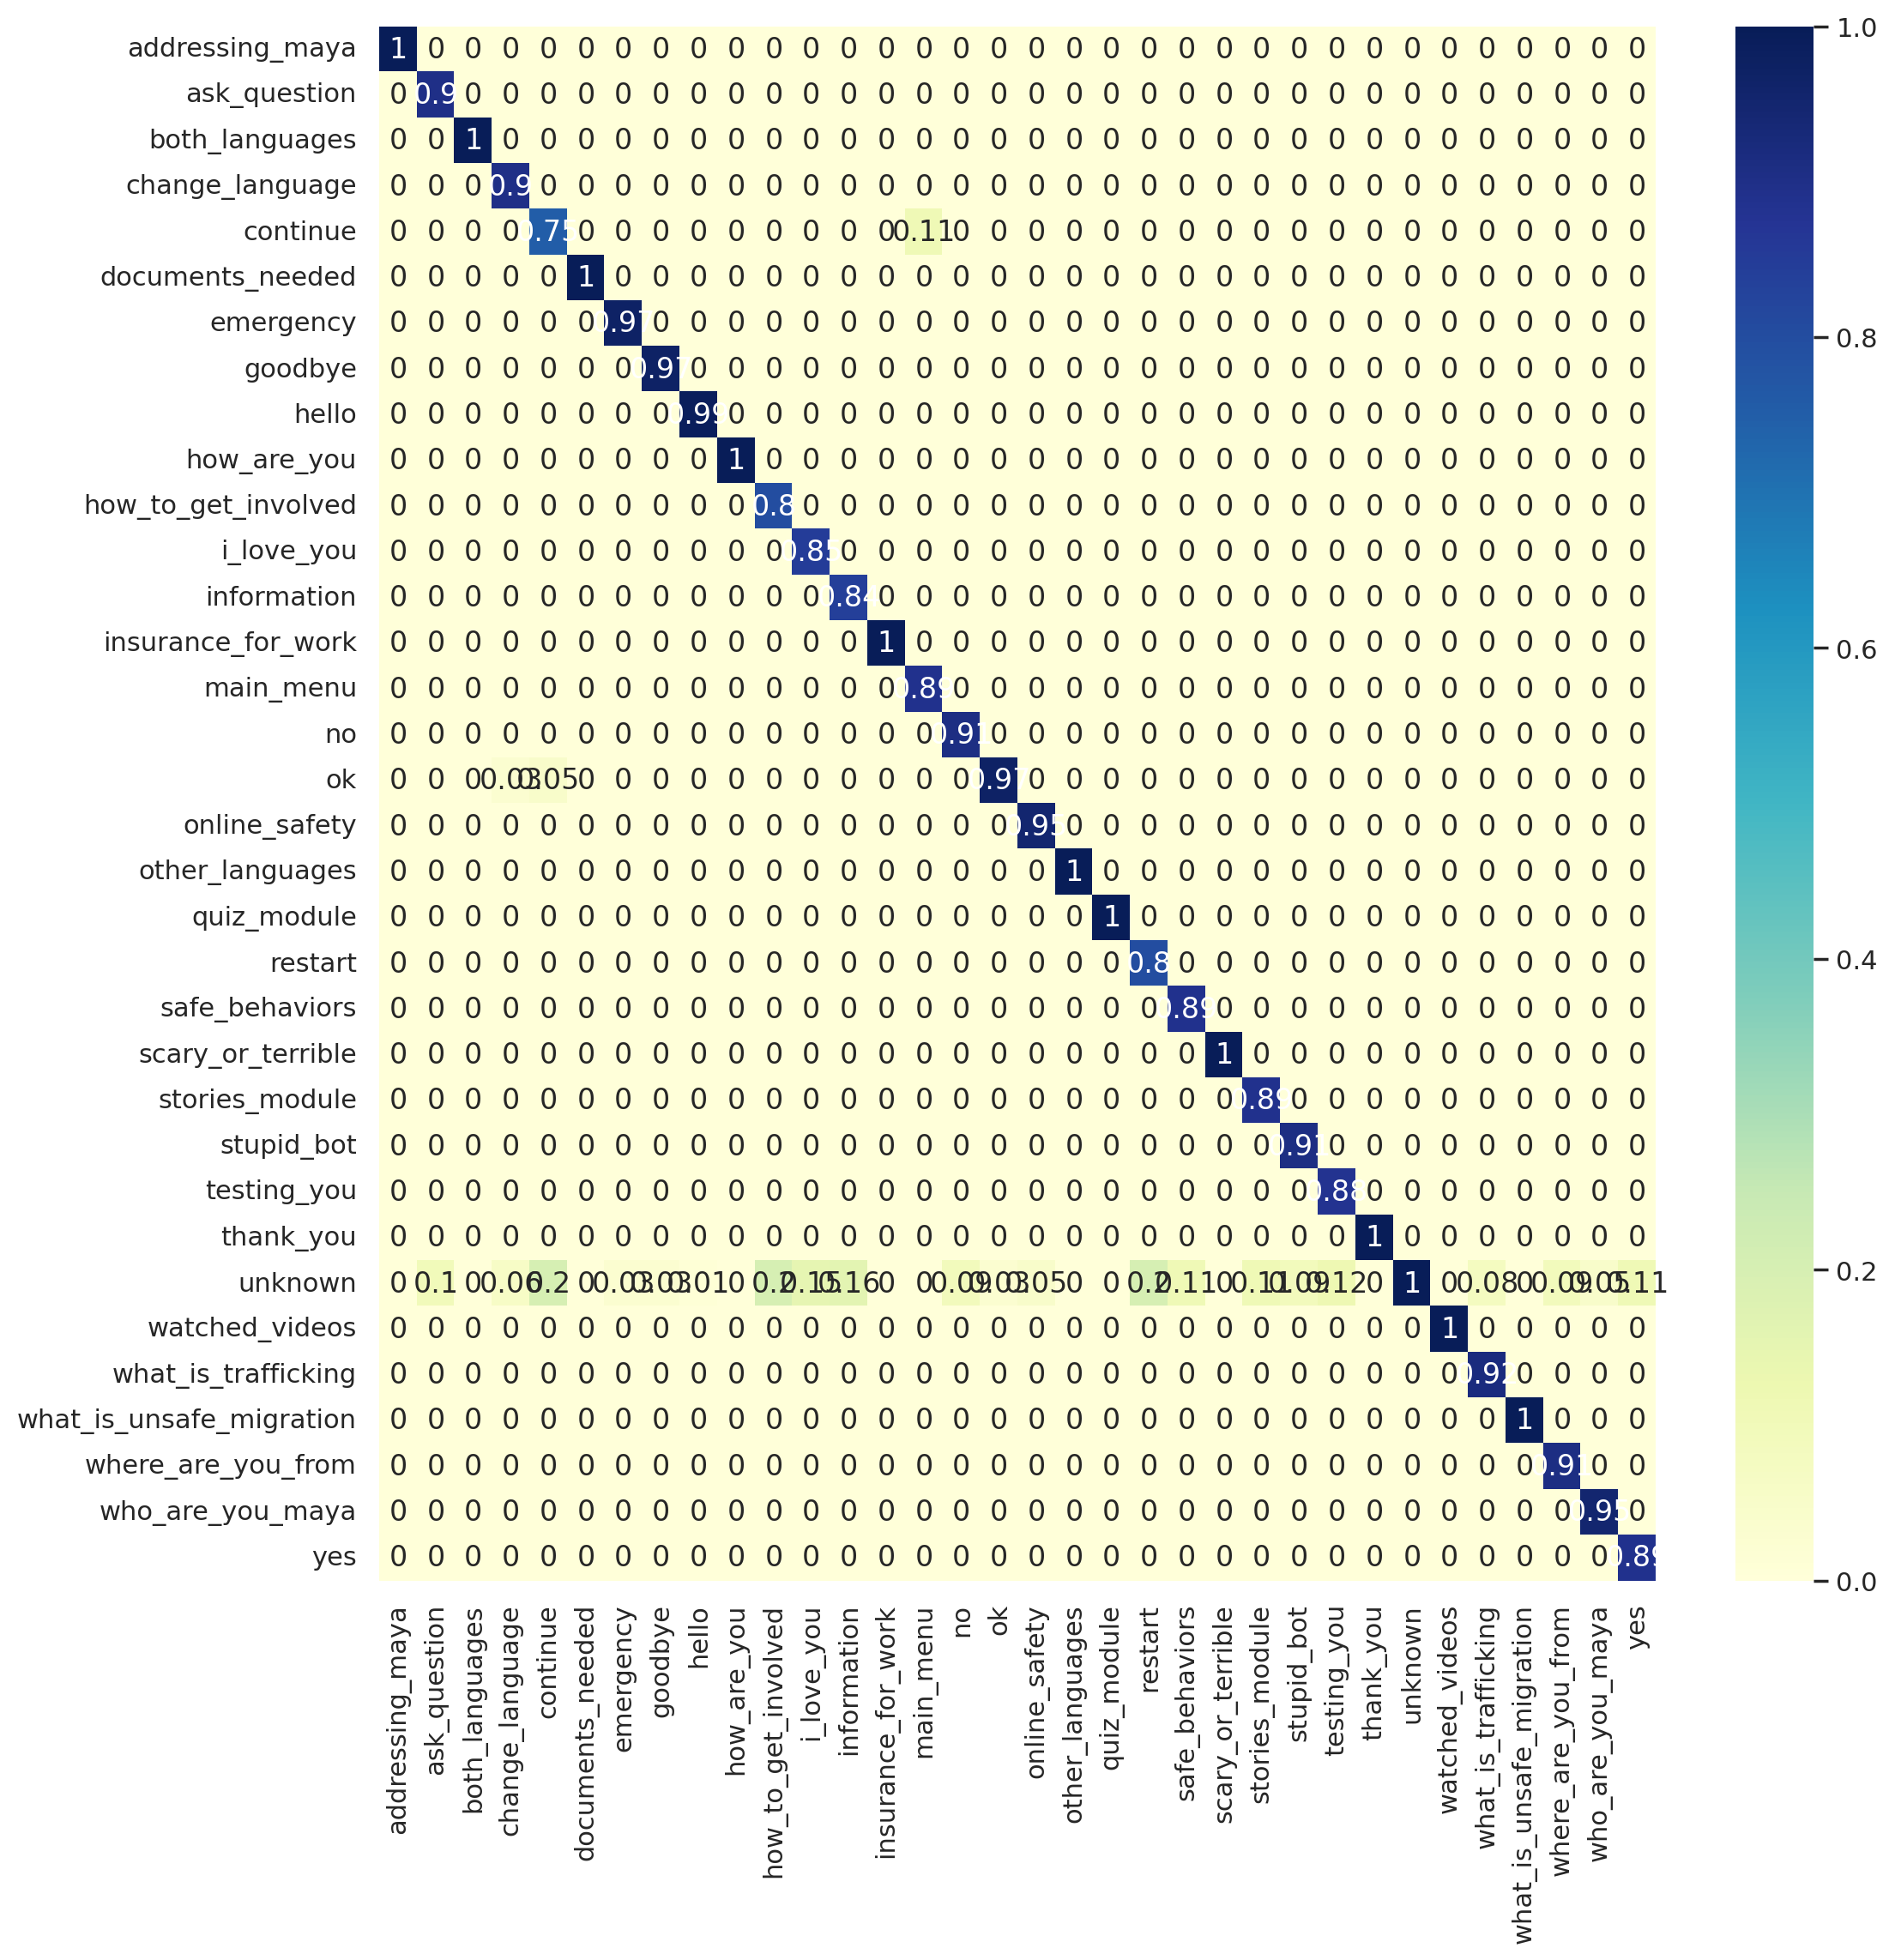

In [33]:
plt.rcParams['figure.figsize'] = [12,12]
fig = plt.figure(figsize=[12,12], dpi=200)
ax = fig.add_subplot(111)
cax = sns.heatmap(confusion_test_pct, annot=True, cmap="YlGnBu")

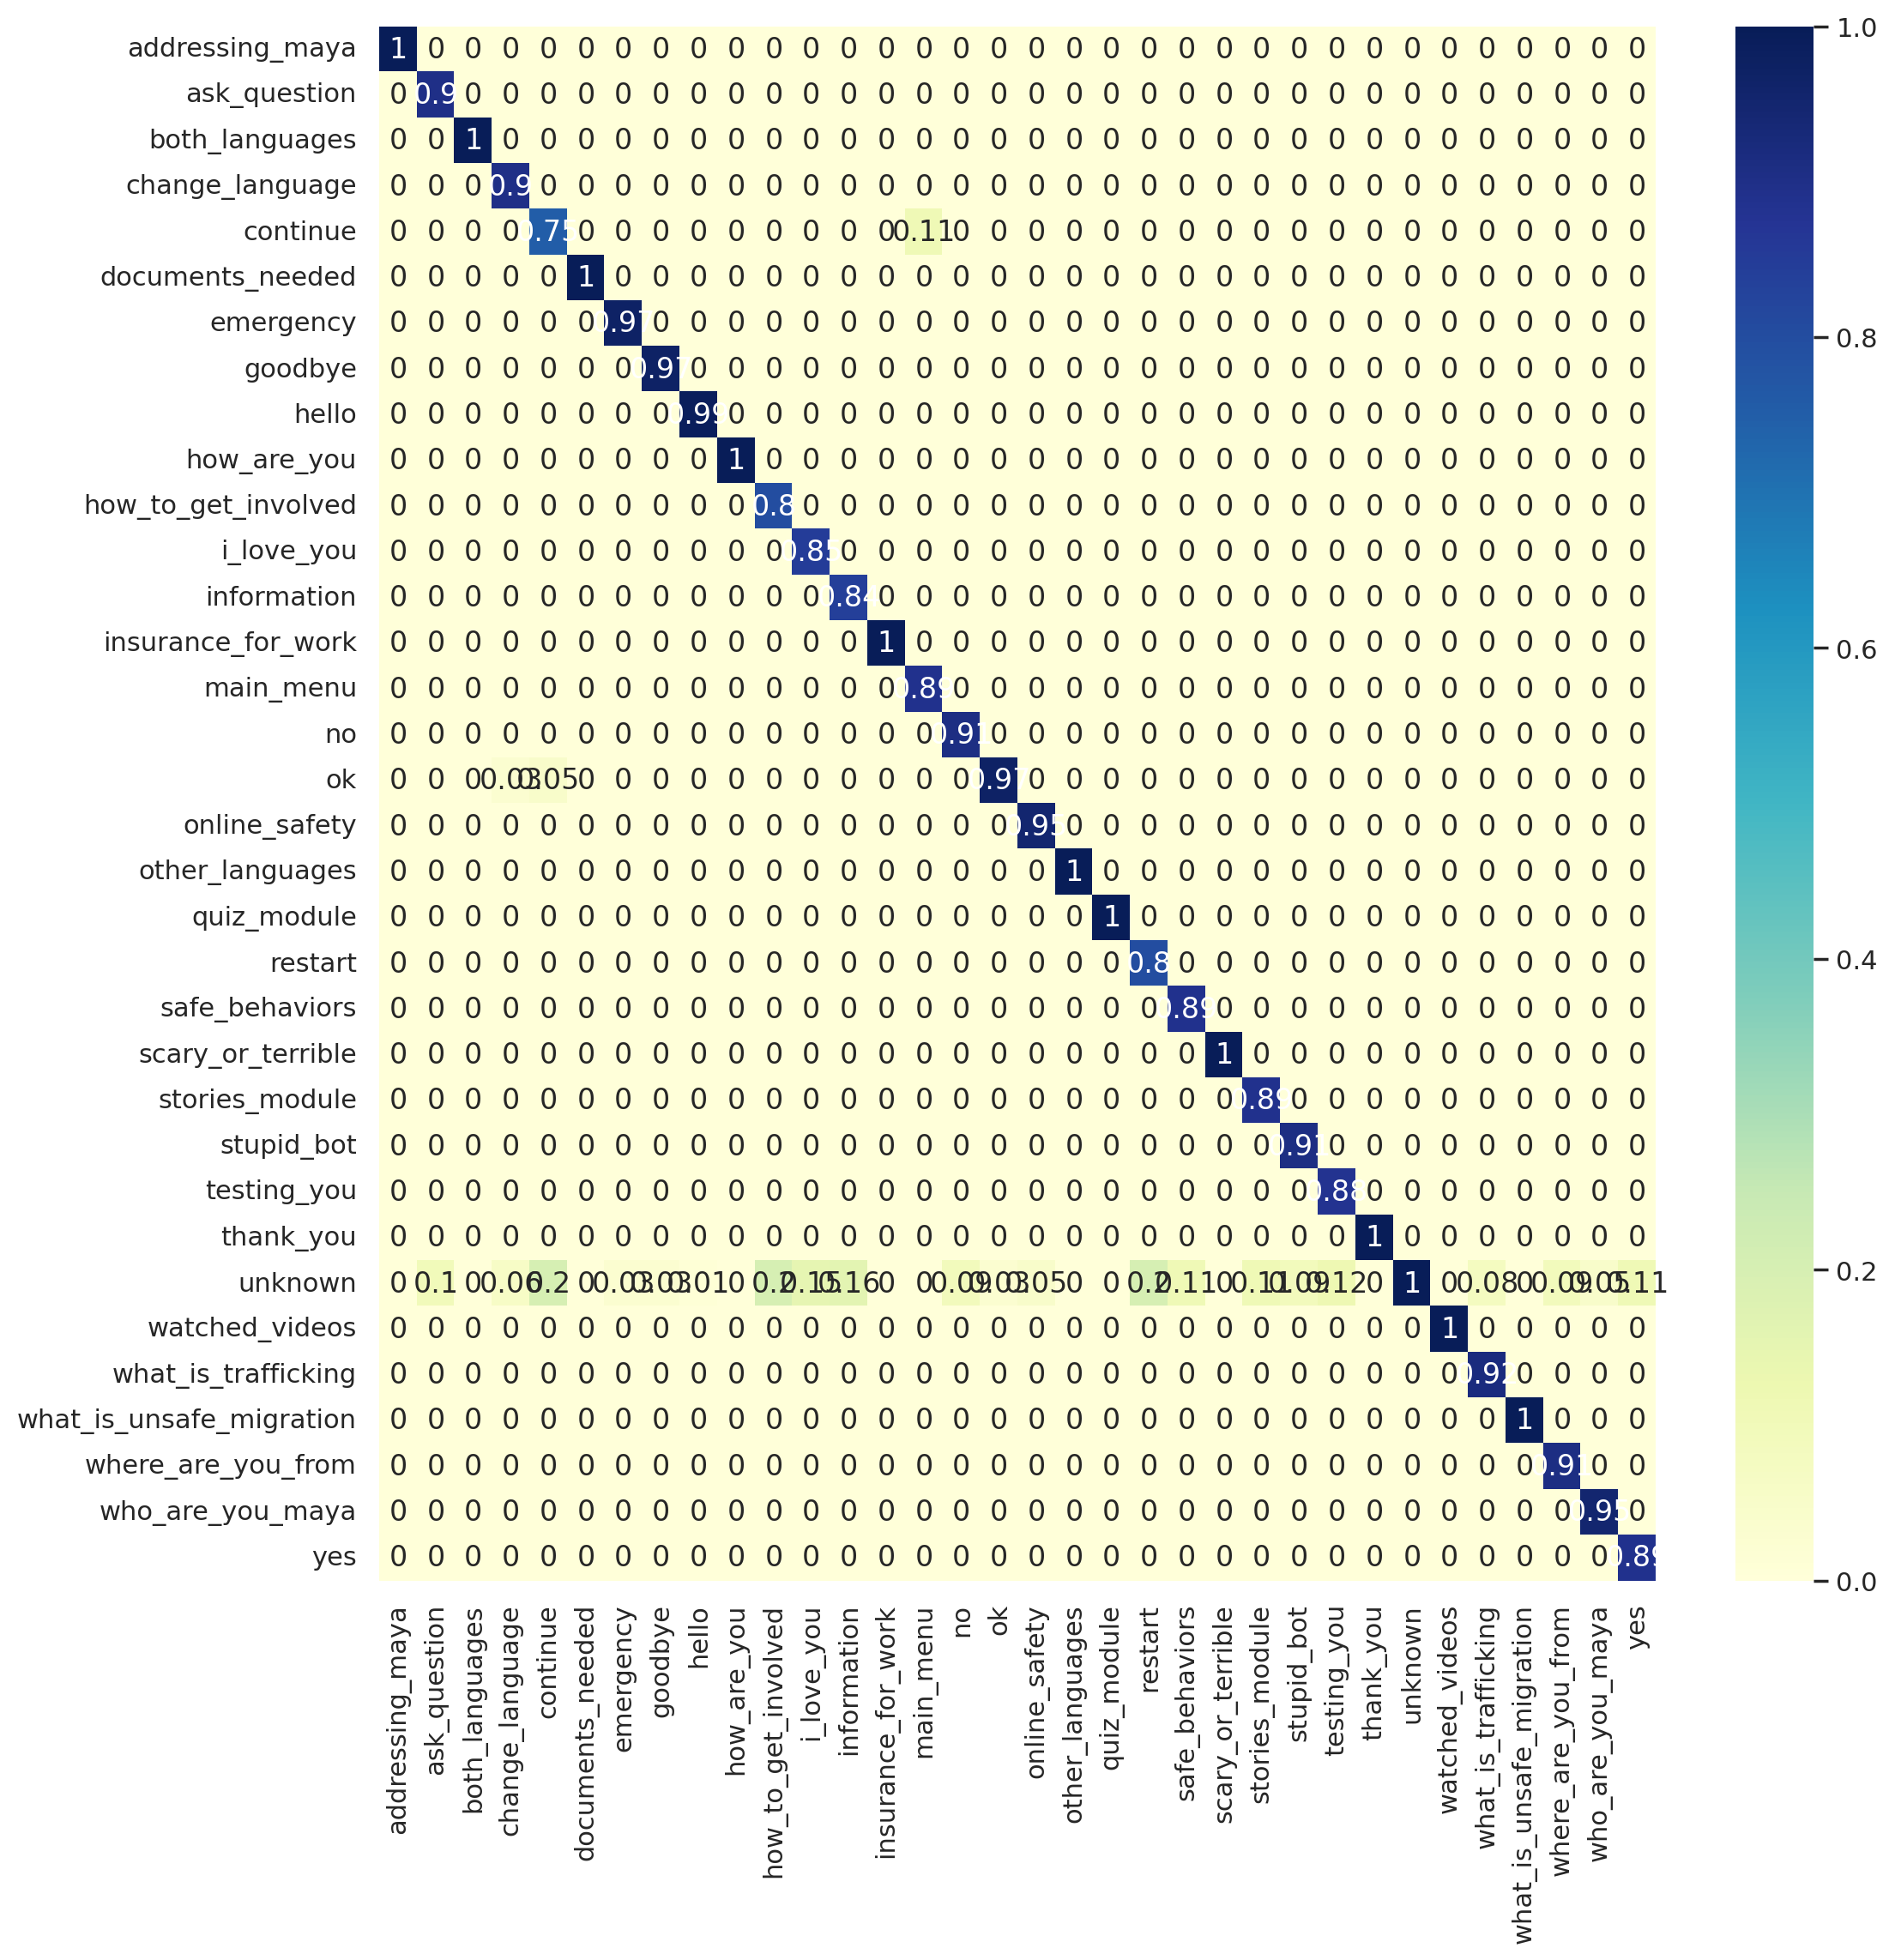

In [34]:
plt.rcParams['figure.figsize'] = [12,12]
fig = plt.figure(figsize=[12,12], dpi=200)
ax = fig.add_subplot(111)
cax = sns.heatmap(confusion_all_pct, annot=True, cmap="YlGnBu")

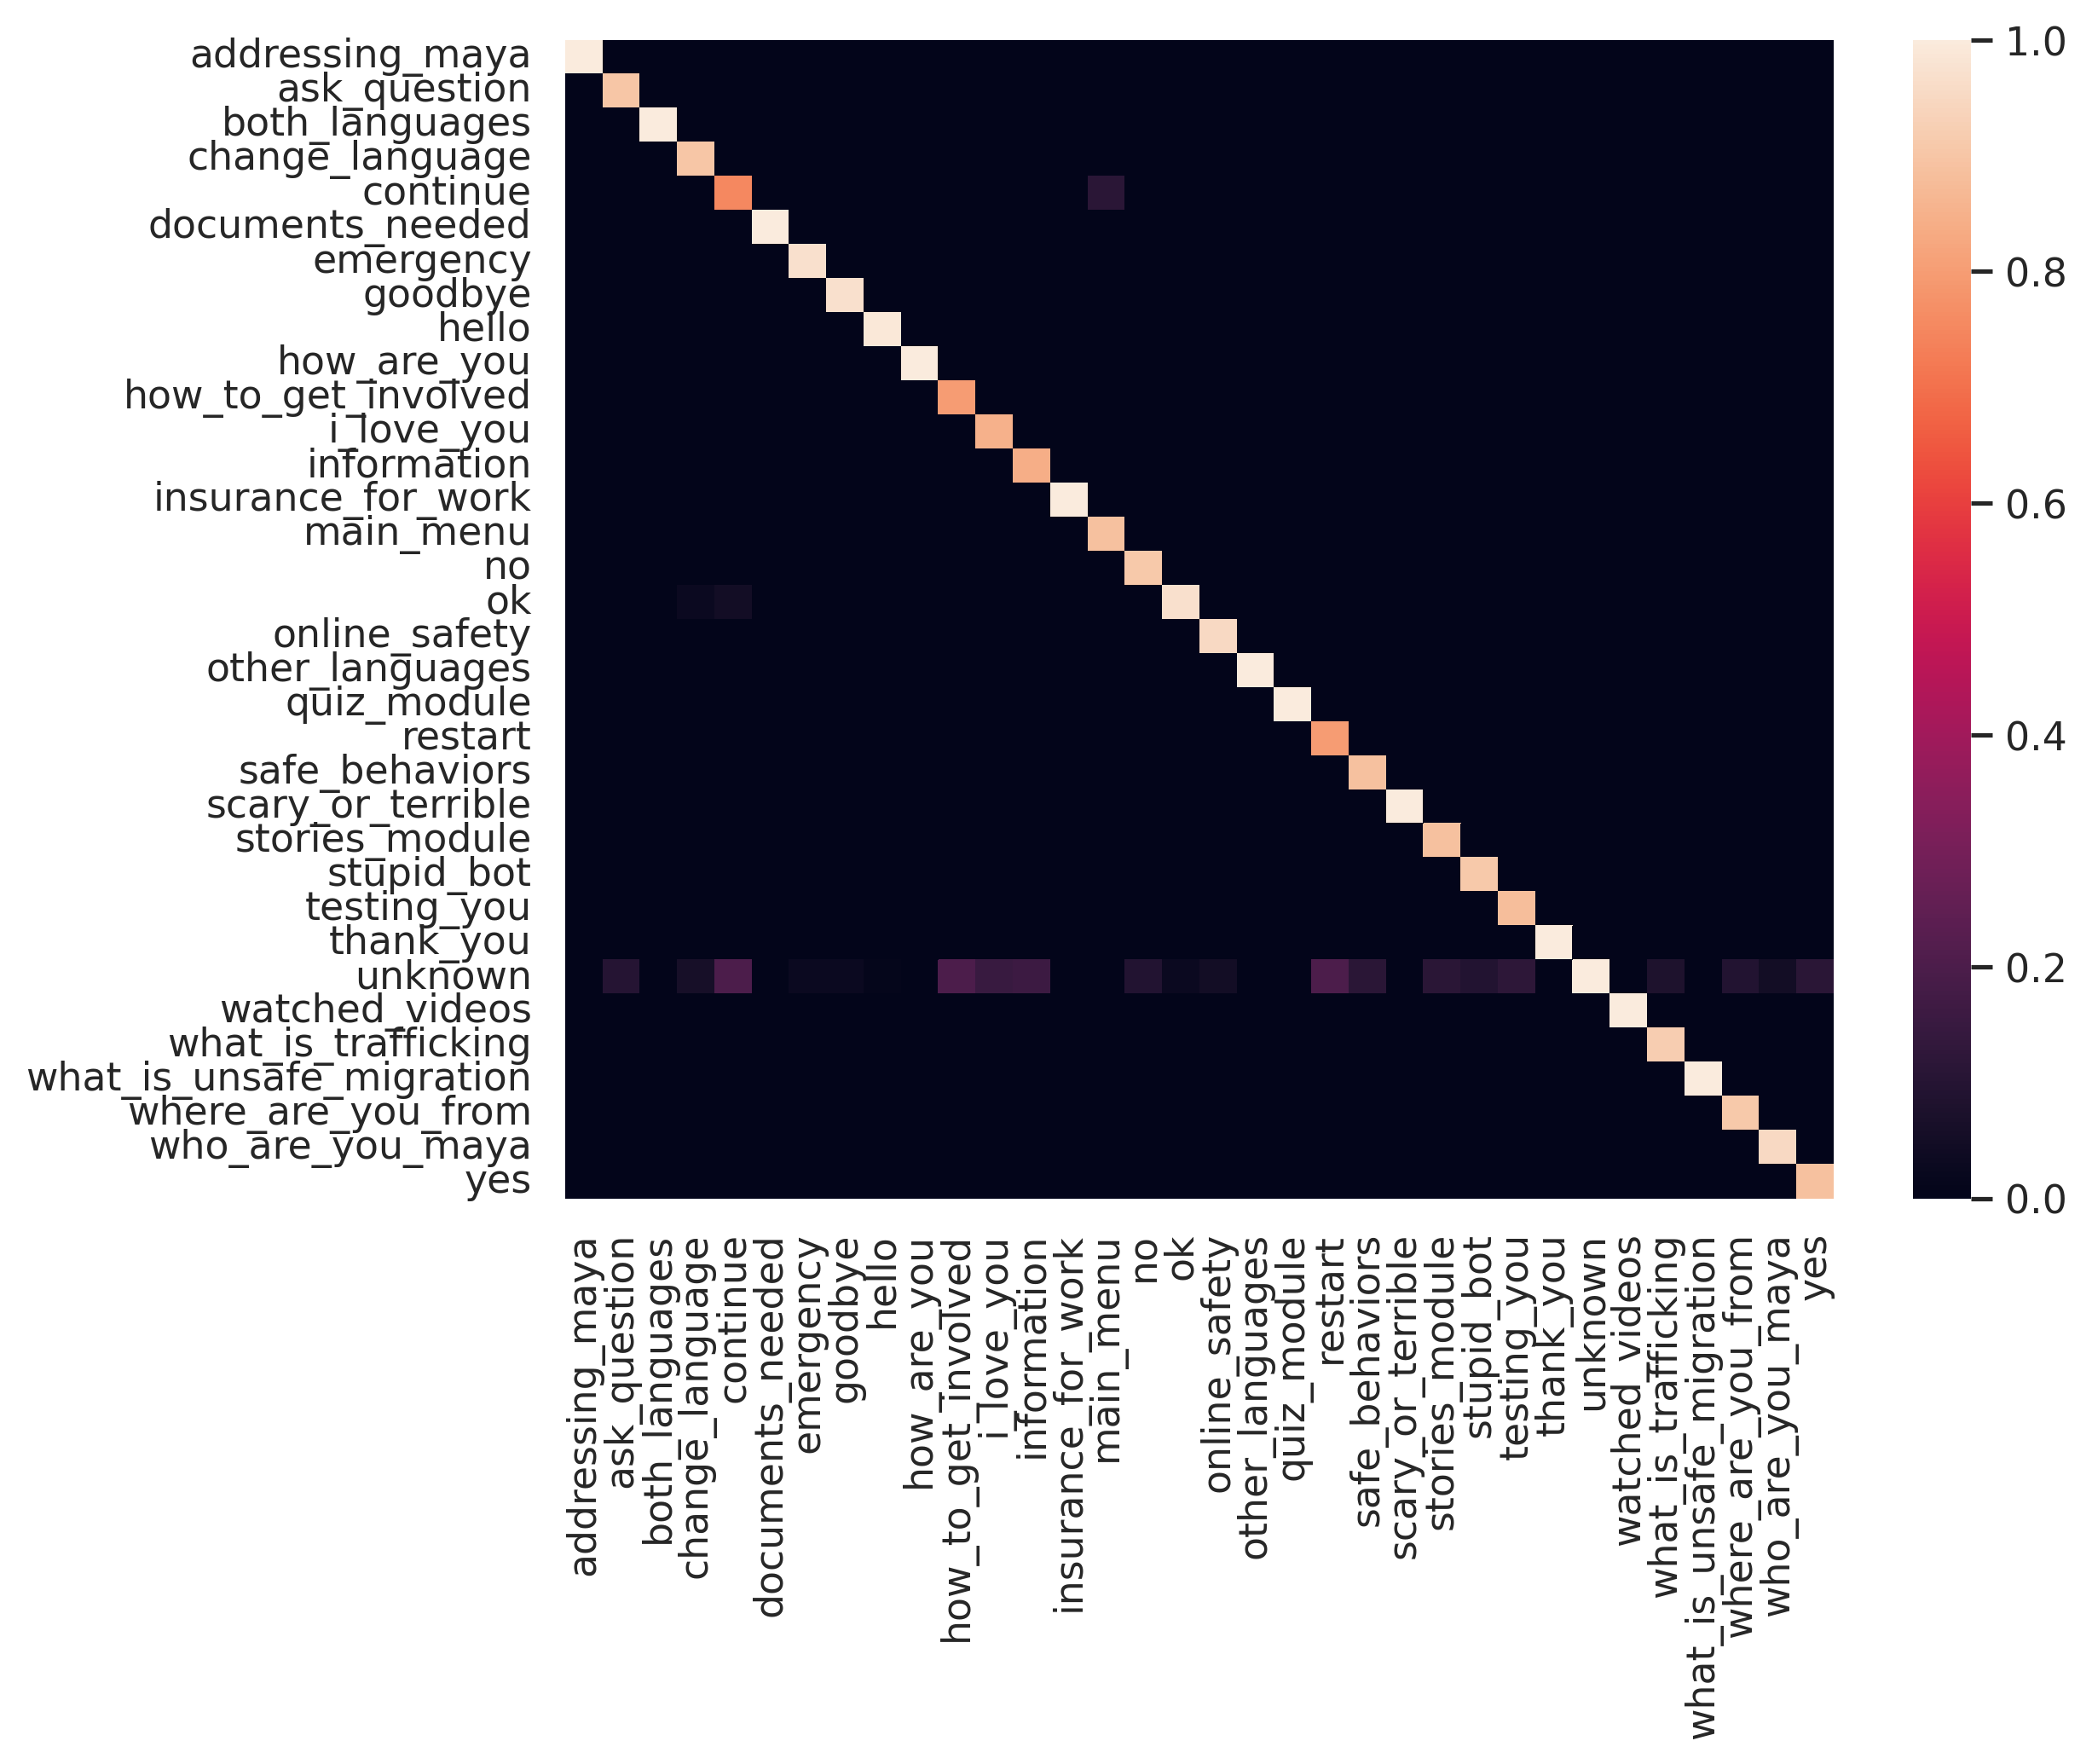

In [35]:
plt.rcParams['figure.figsize'] = [8,6]
fig = plt.figure(figsize=[8,6], dpi=300)
ax = fig.add_subplot(111)
cax = sns.heatmap(confusion_all_pct, vmin=0, vmax=1)

ax.set_xticks(np.arange(len(model.classes_)) + .5)
ax.set_xticklabels(list(model.classes_), rotation=90)

ax.set_yticks(np.arange(len(model.classes_)) + .5)
ax.set_yticklabels(list(model.classes_))

plt.show()

In [36]:
y_pred = model.predict(X)
df['intent_pred'] = pd.Series(y_pred)

In [37]:
incorrect_pred = df['intent_pred'] != df['intent']
unknown = (df['intent'] == 'unknown') | (df['intent_pred'] == 'unknown')
suspicious_rows = incorrect_pred & unknown
reconsider = df[suspicious_rows]

pd.options.display.max_rows = 200
reconsider

utterance   intent  \
505                              How to do the meeting?  unknown   
510                                                  Me  unknown   
534                                                 Me.  unknown   
567                                     Can I say "No"?  unknown   
587                              How to share this link  unknown   
598                                  Come near the gate  unknown   
603                                         Who's there  unknown   
606                                              "Haha"  unknown   
620         want to get information against trafficking  unknown   
643                                                nice  unknown   
649                                        So sad story  unknown   
656                                                  me  unknown   
661                   stay safe from brokers in any way  unknown   
663                  I want to learn something from you  unknown   
673                           Nah, i want to learn more  unknown   
676                                           Tell more  unknown   
689                               Let's see/ let me see  unknown   
693                                      what's my name  unknown   
716                                           oh, is it  unknown   
738                                  Where are you form  unknown   
783                                 I got to know, maya  unknown   
807                  Is this service available anytime?  unknown   
829                                           Now, next  unknown   
833                                       next question  unknown   
847                                     not from Nepali  unknown   
865                            why to say same question  unknown   
880             my language Nepali but word A-Z english  unknown   
886                                 To learn new things  unknown   
889                How do you help in human trafficking  unknown   
892                            what does Love You means  unknown   
980                                               Talks  unknown   
1017                                          ask later  unknown   
1040                                               hmmm  unknown   
1049                                          tell more  unknown   
1064                                               Good  unknown   
1068                                             Shutup  unknown   
1075  I can protect myself anyhow, but please tell m...  unknown   

              intent_pred  
505   how_to_get_involved  
510            i_love_you  
534                 hello  
567                    no  
587   how_to_get_involved  
598        safe_behaviors  
603    where_are_you_from  
606                    ok  
620   what_is_trafficking  
643                    ok  
649        stories_module  
656            i_love_you  
661        safe_behaviors  
663           information  
673           information  
676              continue  
689               goodbye  
693      who_are_you_maya  
716                   yes  
738    where_are_you_from  
783      who_are_you_maya  
807         online_safety  
829              continue  
833              continue  
847       change_language  
865           testing_you  
880       change_language  
886           information  
889   what_is_trafficking  
892            i_love_you  
980               restart  
1017         ask_question  
1040                  yes  
1049             continue  
1064                   ok  
1068           stupid_bot  
1075            emergency

In [38]:
# Group the dataframe by intent, highlight the first utterance of every intent
pd.concat([g.iloc[[0]] for (label, g) in df.groupby('intent')])

utterance  \
130                                          "Maya dd"   
21                         "Can I ask something else?"   
12                             "Both languageSpeak me"   
24   "Can you give me  answer  in nepali language plz"   
31                                          "Continue"   
35              "Do i need a passport to work abroad?"   
26                                  "Can you help me?"   
8                                                "BYE"   
46                                           "HY MAYA"   
54                     "Hello how are you doing today"   
89   "I am really happy to join with you,I am searc...   
91                                        "I like you"   
120                               "I. Want. To. Learn"   
34                   "Do I need insurance to migrate?"   
0                                             "*menu*"   
149                                               "No"   
43                                              "Good"   
28              "Can you tell me about online safety?"   
10               "Balas bahasa Indonesia biar tau mbk"   
174                                             "Quiz"   
350                                          "restart"   
3                                "2. Safety behaviors"   
157                                           "Oh no!"   
22                                  "Can I read story"   
7                                    "Are you stupid?"   
4    "A question the system is not supposed to reco...   
1                                        ", thank you"   
482                                             Is it?   
104                                "I saw your videos"   
2                             "1. What is trafficking"   
107            "I want to know more about immigration"   
224                               "Where are you from"   
6                                     "Are you Muslim"   
243                                              "Yas"   

                       intent               intent_pred  
130           addressing_maya           addressing_maya  
21               ask_question              ask_question  
12             both_languages            both_languages  
24            change_language           change_language  
31                   continue                  continue  
35           documents_needed          documents_needed  
26                  emergency                 emergency  
8                     goodbye                   goodbye  
46                      hello                     hello  
54                how_are_you               how_are_you  
89        how_to_get_involved       how_to_get_involved  
91                 i_love_you                i_love_you  
120               information               information  
34         insurance_for_work        insurance_for_work  
0                   main_menu                 main_menu  
149                        no                        no  
43                         ok                        ok  
28              online_safety             online_safety  
10            other_languages           other_languages  
174               quiz_module               quiz_module  
350                   restart                   restart  
3              safe_behaviors            safe_behaviors  
157         scary_or_terrible         scary_or_terrible  
22             stories_module            stories_module  
7                  stupid_bot                stupid_bot  
4                 testing_you               testing_you  
1                   thank_you                 thank_you  
482                   unknown                   unknown  
104            watched_videos            watched_videos  
2         what_is_trafficking       what_is_trafficking  
107  what_is_unsafe_migration  what_is_unsafe_migration  
224        where_are_you_from        where_are_you_from  
6            who_are_you_maya          who_are_you_maya  
243                       yes             

In [39]:
intent_dict = df['intent'].to_dict()
corrections = {22: 'stories_module', 481: 'i_love_you'}
intent_dict.update(corrections)
df['corrected'] = pd.Series(corrections)
df.iloc[list(corrections.keys())]

utterance          intent     intent_pred       corrected
22   "Can I read story"  stories_module  stories_module  stories_module
481           Hi, cutie      i_love_you      i_love_you      i_love_you

In [54]:
# Save the trained model
with open('./saved_models/model_1.pkl', 'wb') as file: 
    pickle.dump(model, file)

In [56]:
# Load the trained model
with open('./saved_models/model_1.pkl', 'rb') as file:
    trained_model = pickle.load(file)

In [59]:
trained_model.predict(X)

array(['main_menu', 'thank_you', 'what_is_trafficking', ...,
       'ask_question', 'how_are_you', 'stories_module'], dtype='<U24')

In [63]:
def revise_unknown_labels(df, reconsider, your_labels):
    for i_recon, (idx, row) in enumerate(reconsider.iterrows()):
        print()
        print(f'{idx}: "{row["utterance"]}"   [l]abel: {row["intent"]}   [p]red: {row["intent_pred"]}')
        your_label = input(f'YOUR LABEL ([l]abel="{row["intent"]}", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="{row["intent_pred"]}"): ')
        try:
            your_label = int(your_label)
            your_label = df['intent'][your_label]
        except ValueError:
            your_label = your_label.lower().strip().replace(' ', '_').replace('-', '_')
            if your_label in ('p', 'pred', ''):
                your_label = row["intent_pred"]
            elif your_label in ('label', 'l'):
                your_label = row["intent"]
            elif your_label in ('u', 'unk', 'unknown', 'unkown', 'uknown', 'nan'):
                your_label = 'unknown'
            elif your_label in ('s', 'skip'):
                continue
            elif your_label in ('exit', 'x'):
                break
        action = 'not changing'
        if your_label in df['intent'].values:
            action = 'CORRECTION'
        elif your_labels[idx] == your_label:
            action = 'not changing'
        else:
            resp = input('Are you sure you want to create a new intent label "{your_label}"?')
            if resp.lower.strip() and resp.lower.strip()[0] == 'y':
                action = 'NEW INTENT'
        print(f'{action}:  {your_labels[idx]} => {your_label}')
        if action in ('CORRECTION', 'NEW INTENT'):
            your_labels[idx] = your_label
    df['your_label'] = your_labels
    df[suspicious_rows]
    return df

In [64]:
incorrect_pred = df['intent_pred'] != df['intent']
unknown = (df['intent'] == 'unknown') | (df['intent_pred'] == 'unknown')
suspicious_rows = incorrect_pred & unknown
reconsider = df[suspicious_rows]

your_labels = list(df['intent'].copy())
df = revise_unknown_labels(df=df, reconsider=reconsider, your_labels=your_labels)


510: "Me"   [l]abel: unknown   [p]red: i_love_you


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="i_love_you"):  l


CORRECTION:  unknown => unknown

534: "Me."   [l]abel: unknown   [p]red: hello


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="hello"):  l


CORRECTION:  unknown => unknown

567: "Can I say "No"?"   [l]abel: unknown   [p]red: no


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="no"):  l


CORRECTION:  unknown => unknown

587: "How to share this link"   [l]abel: unknown   [p]red: how_to_get_involved


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="how_to_get_involved"):  l


CORRECTION:  unknown => unknown

598: "Come near the gate"   [l]abel: unknown   [p]red: safe_behaviors


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="safe_behaviors"):  l


CORRECTION:  unknown => unknown

603: "Who's there"   [l]abel: unknown   [p]red: where_are_you_from


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="where_are_you_from"):  l


CORRECTION:  unknown => unknown

606: ""Haha""   [l]abel: unknown   [p]red: ok


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="ok"):  l


CORRECTION:  unknown => unknown

620: "want to get information against trafficking"   [l]abel: unknown   [p]red: what_is_trafficking


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="what_is_trafficking"):  l


CORRECTION:  unknown => unknown

637: "cautious, why?"   [l]abel: unknown   [p]red: safe_behaviors


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="safe_behaviors"):  l


CORRECTION:  unknown => unknown

643: "nice"   [l]abel: unknown   [p]red: ok


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="ok"):  l


CORRECTION:  unknown => unknown

656: "me"   [l]abel: unknown   [p]red: i_love_you


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="i_love_you"):  l


CORRECTION:  unknown => unknown

661: "stay safe from brokers in any way"   [l]abel: unknown   [p]red: safe_behaviors


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="safe_behaviors"):  l


CORRECTION:  unknown => unknown

663: "I want to learn something from you"   [l]abel: unknown   [p]red: information


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="information"):  l


CORRECTION:  unknown => unknown

673: "Nah, i want to learn more"   [l]abel: unknown   [p]red: information


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="information"):  l


CORRECTION:  unknown => unknown

676: "Tell more"   [l]abel: unknown   [p]red: continue


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="continue"):  l


CORRECTION:  unknown => unknown

689: "Let's see/ let me see"   [l]abel: unknown   [p]red: goodbye


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="goodbye"):  l


CORRECTION:  unknown => unknown

693: "what's my name"   [l]abel: unknown   [p]red: who_are_you_maya


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="who_are_you_maya"):  l


CORRECTION:  unknown => unknown

712: "which place"   [l]abel: unknown   [p]red: where_are_you_from


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="where_are_you_from"):  


CORRECTION:  unknown => where_are_you_from

716: "oh, is it"   [l]abel: unknown   [p]red: yes


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="yes"):  l


CORRECTION:  unknown => unknown

762: "ask question"   [l]abel: unknown   [p]red: ask_question


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="ask_question"):  


CORRECTION:  unknown => ask_question

764: "ask question"   [l]abel: unknown   [p]red: ask_question


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="ask_question"):  


CORRECTION:  unknown => ask_question

783: "I got to know, maya"   [l]abel: unknown   [p]red: who_are_you_maya


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="who_are_you_maya"):  l


CORRECTION:  unknown => unknown

803: "How human trafficking is being done"   [l]abel: unknown   [p]red: what_is_trafficking


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="what_is_trafficking"):  


CORRECTION:  unknown => what_is_trafficking

807: "Is this service available anytime?"   [l]abel: unknown   [p]red: online_safety


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="online_safety"):  l


CORRECTION:  unknown => unknown

815: "ask question"   [l]abel: unknown   [p]red: ask_question


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="ask_question"):  p


CORRECTION:  unknown => ask_question

829: "Now, next"   [l]abel: unknown   [p]red: continue


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="continue"):  l


CORRECTION:  unknown => unknown

833: "next question"   [l]abel: unknown   [p]red: continue


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="continue"):  l


CORRECTION:  unknown => unknown

847: "not from Nepali"   [l]abel: unknown   [p]red: change_language


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="change_language"):  l


CORRECTION:  unknown => unknown

862: "ask question"   [l]abel: unknown   [p]red: ask_question


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="ask_question"):  p


CORRECTION:  unknown => ask_question

865: "why to say same question"   [l]abel: unknown   [p]red: testing_you


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="testing_you"):  l


CORRECTION:  unknown => unknown

880: "my language Nepali but word A-Z english"   [l]abel: unknown   [p]red: change_language


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="change_language"):  l


CORRECTION:  unknown => unknown

886: "To learn new things"   [l]abel: unknown   [p]red: information


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="information"):  l


CORRECTION:  unknown => unknown

889: "How do you help in human trafficking"   [l]abel: unknown   [p]red: what_is_trafficking


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="what_is_trafficking"):  l


CORRECTION:  unknown => unknown

914: "Love"   [l]abel: unknown   [p]red: i_love_you


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="i_love_you"):  p


CORRECTION:  unknown => i_love_you

935: "I want to work with you if possible please let me join on your team"   [l]abel: unknown   [p]red: how_to_get_involved


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="how_to_get_involved"):  


CORRECTION:  unknown => how_to_get_involved

945: "Name please."   [l]abel: unknown   [p]red: who_are_you_maya


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="who_are_you_maya"):  


CORRECTION:  unknown => who_are_you_maya

957: "want to hear a story."   [l]abel: unknown   [p]red: stories_module


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="stories_module"):  


CORRECTION:  unknown => stories_module

980: "Talks"   [l]abel: unknown   [p]red: restart


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="restart"):  l


CORRECTION:  unknown => unknown

1017: "ask later"   [l]abel: unknown   [p]red: ask_question


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="ask_question"):  l


CORRECTION:  unknown => unknown

1031: "Stop sending text to me"   [l]abel: unknown   [p]red: online_safety


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="online_safety"):  l


CORRECTION:  unknown => unknown

1040: "hmmm"   [l]abel: unknown   [p]red: yes


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="yes"):  l


CORRECTION:  unknown => unknown

1049: "tell more"   [l]abel: unknown   [p]red: continue


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="continue"):  l


CORRECTION:  unknown => unknown

1064: "Good"   [l]abel: unknown   [p]red: ok


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="ok"):  l


CORRECTION:  unknown => unknown

1068: "Shutup"   [l]abel: unknown   [p]red: stupid_bot


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="stupid_bot"):  l


CORRECTION:  unknown => unknown

1075: "I can protect myself anyhow, but please tell me how to help if I find someone in this situation"   [l]abel: unknown   [p]red: emergency


YOUR LABEL ([l]abel="unknown", [p]red, e[x]it, [s]kip, <your_suggestion>, [ENTER]="emergency"):  l


CORRECTION:  unknown => unknown


In [85]:
corrected_vals = []
for l, c, y in zip(df['intent'], df['corrected'], df['your_label']):
    if not pd.isna(c): # if it's not a missing value, then add it to the list
        corrected_vals.append(c)

In [86]:
corrected_vals

['stories_module', 'i_love_you']

In [87]:
your_corrected = []
for l, c, y in zip(df['intent'], df['corrected'], df['your_label']):
    if not pd.isna(c): # .isna() used to detect the missing values
        your_corrected.append(c)
    elif l != y:
        your_corrected.append(y)
    else:
        your_corrected.append(l)
df['your_corrected'] = your_corrected

In [88]:
df['your_corrected']

0                 main_menu
1                 thank_you
2       what_is_trafficking
3            safe_behaviors
4               testing_you
               ...         
1089            information
1090         both_languages
1091           ask_question
1092            how_are_you
1093         stories_module
Name: your_corrected, Length: 1094, dtype: object

In [89]:
df[df['intent'] != df['your_corrected']]

utterance   intent  \
712                                        which place  unknown   
762                                       ask question  unknown   
764                                       ask question  unknown   
803                How human trafficking is being done  unknown   
815                                       ask question  unknown   
862                                       ask question  unknown   
914                                               Love  unknown   
935  I want to work with you if possible please let...  unknown   
945                                       Name please.  unknown   
957                              want to hear a story.  unknown   

             intent_pred corrected           your_label       your_corrected  
712   where_are_you_from       NaN   where_are_you_from   where_are_you_from  
762         ask_question       NaN         ask_question         ask_question  
764         ask_question       NaN         ask_question         ask_question  
803  what_is_trafficking       NaN  what_is_trafficking  what_is_trafficking  
815         ask_question       NaN         ask_question         ask_question  
862         ask_question       NaN         ask_question         ask_question  
914           i_love_you       NaN           i_love_you           i_love_you  
935  how_to_get_involved       NaN  how_to_get_involved  how_to_get_involved  
945     who_are_you_maya       NaN     who_are_you_maya     who_are_you_maya  
957       stories_module       NaN       stories_module       stories_module

In [92]:
df['intent'] == df['your_corrected']

0       True
1       True
2       True
3       True
4       True
        ... 
1089    True
1090    True
1091    True
1092    True
1093    True
Length: 1094, dtype: bool

In [94]:
# overwrite the 'intent' column with 'your_corrected' column values and delete it from the dataframe
df['intent'] = df.pop('your_corrected')
# remove the 'corrected' column from the dataframe
df.pop('corrected')
# save the dataframe as CSV file
df.to_csv(DATA_DIR / 'utterance_intent_pairs_revised.csv')
df

utterance               intent  \
0                                              "*menu*"            main_menu   
1                                         ", thank you"            thank_you   
2                              "1. What is trafficking"  what_is_trafficking   
3                                 "2. Safety behaviors"       safe_behaviors   
4     "A question the system is not supposed to reco...          testing_you   
...                                                 ...                  ...   
1089                             Tell me more about it.          information   
1090                               nepalese and english       both_languages   
1091                     I'd like to ask you something.         ask_question   
1092                                  How was your day?          how_are_you   
1093                                    tell me a story       stories_module   

              intent_pred           your_label  
0               main_menu            main_menu  
1               thank_you            thank_you  
2     what_is_trafficking  what_is_trafficking  
3          safe_behaviors       safe_behaviors  
4             testing_you          testing_you  
...                   ...                  ...  
1089          information          information  
1090       both_languages       both_languages  
1091         ask_question         ask_question  
1092          how_are_you          how_are_you  
1093       stories_module       stories_module  

[1094 rows x 4 columns]

In [97]:
model.fit(X, df['intent'])
df['intent_pred'] = model.predict(X)

In [98]:
sorted(df['intent'].unique())

['addressing_maya',
 'ask_question',
 'both_languages',
 'change_language',
 'continue',
 'documents_needed',
 'emergency',
 'goodbye',
 'hello',
 'how_are_you',
 'how_to_get_involved',
 'i_love_you',
 'information',
 'insurance_for_work',
 'main_menu',
 'no',
 'ok',
 'online_safety',
 'other_languages',
 'quiz_module',
 'restart',
 'safe_behaviors',
 'scary_or_terrible',
 'stories_module',
 'stupid_bot',
 'testing_you',
 'thank_you',
 'unknown',
 'watched_videos',
 'what_is_trafficking',
 'what_is_unsafe_migration',
 'where_are_you_from',
 'who_are_you_maya',
 'yes']

In [99]:
def show_confusion(df):
    confusion = pd.DataFrame(
        confusion_matrix(
            df['intent'], df['intent_pred'], labels=model.classes_),
        index=model.classes_,
        columns=model.classes_)
    confusion = confusion / confusion.T.sum()
    plt.rcParams['figure.figsize'] = [12,12]
    fig = plt.figure(figsize=[12,12], dpi=200)
    ax = fig.add_subplot(111)
    cax = sns.heatmap(confusion, annot=True, cmap="YlGnBu")
    return confusion

addressing_maya  ask_question  both_languages  \
addressing_maya                       1.0      0.000000             0.0   
ask_question                          0.0      1.000000             0.0   
both_languages                        0.0      0.000000             1.0   
change_language                       0.0      0.000000             0.0   
continue                              0.0      0.000000             0.0   
documents_needed                      0.0      0.000000             0.0   
emergency                             0.0      0.000000             0.0   
goodbye                               0.0      0.000000             0.0   
hello                                 0.0      0.000000             0.0   
how_are_you                           0.0      0.000000             0.0   
how_to_get_involved                   0.0      0.000000             0.0   
i_love_you                            0.0      0.000000             0.0   
information                           0.0      0.000000             0.0   
insurance_for_work                    0.0      0.000000             0.0   
main_menu                             0.0      0.000000             0.0   
no                                    0.0      0.000000             0.0   
ok                                    0.0      0.000000             0.0   
online_safety                         0.0      0.000000             0.0   
other_languages                       0.0      0.000000             0.0   
quiz_module                           0.0      0.000000             0.0   
restart                               0.0      0.000000             0.0   
safe_behaviors                        0.0      0.000000             0.0   
scary_or_terrible                     0.0      0.000000             0.0   
stories_module                        0.0      0.000000             0.0   
stupid_bot                            0.0      0.000000             0.0   
testing_you                           0.0      0.000000             0.0   
thank_you                             0.0      0.000000             0.0   
unknown                               0.0      0.111111             0.0   
watched_videos                        0.0      0.000000             0.0   
what_is_trafficking                   0.0      0.000000             0.0   
what_is_unsafe_migration              0.0      0.000000             0.0   
where_are_you_from                    0.0      0.000000             0.0   
who_are_you_maya                      0.0      0.000000             0.0   
yes                                   0.0      0.000000             0.0   

                          change_language  continue  documents_needed  \
addressing_maya                  0.000000    0.0000               0.0   
ask_question                     0.000000    0.0000               0.0   
both_languages                   0.000000    0.0000               0.0   
change_language                  1.000000    0.0000               0.0   
continue                         0.000000    0.9375               0.0   
documents_needed                 0.000000    0.0000               1.0   
emergency                        0.000000    0.0000               0.0   
goodbye                          0.000000    0.0000               0.0   
hello                            0.000000    0.0000               0.0   
how_are_you                      0.000000    0.0000               0.0   
how_to_get_involved              0.000000    0.0000               0.0   
i_love_you                       0.000000    0.0000               0.0   
information                      0.000000    0.0000               0.0   
insurance_for_work               0.000000    0.0000               0.0   
main_menu                        0.000000    0.0000               0.0   
no                               0.000000    0.0000               0.0   
ok                               0.035714    0.0625               0.0   
online_safety                    0.000000    0.0000               0.0   
other_languag

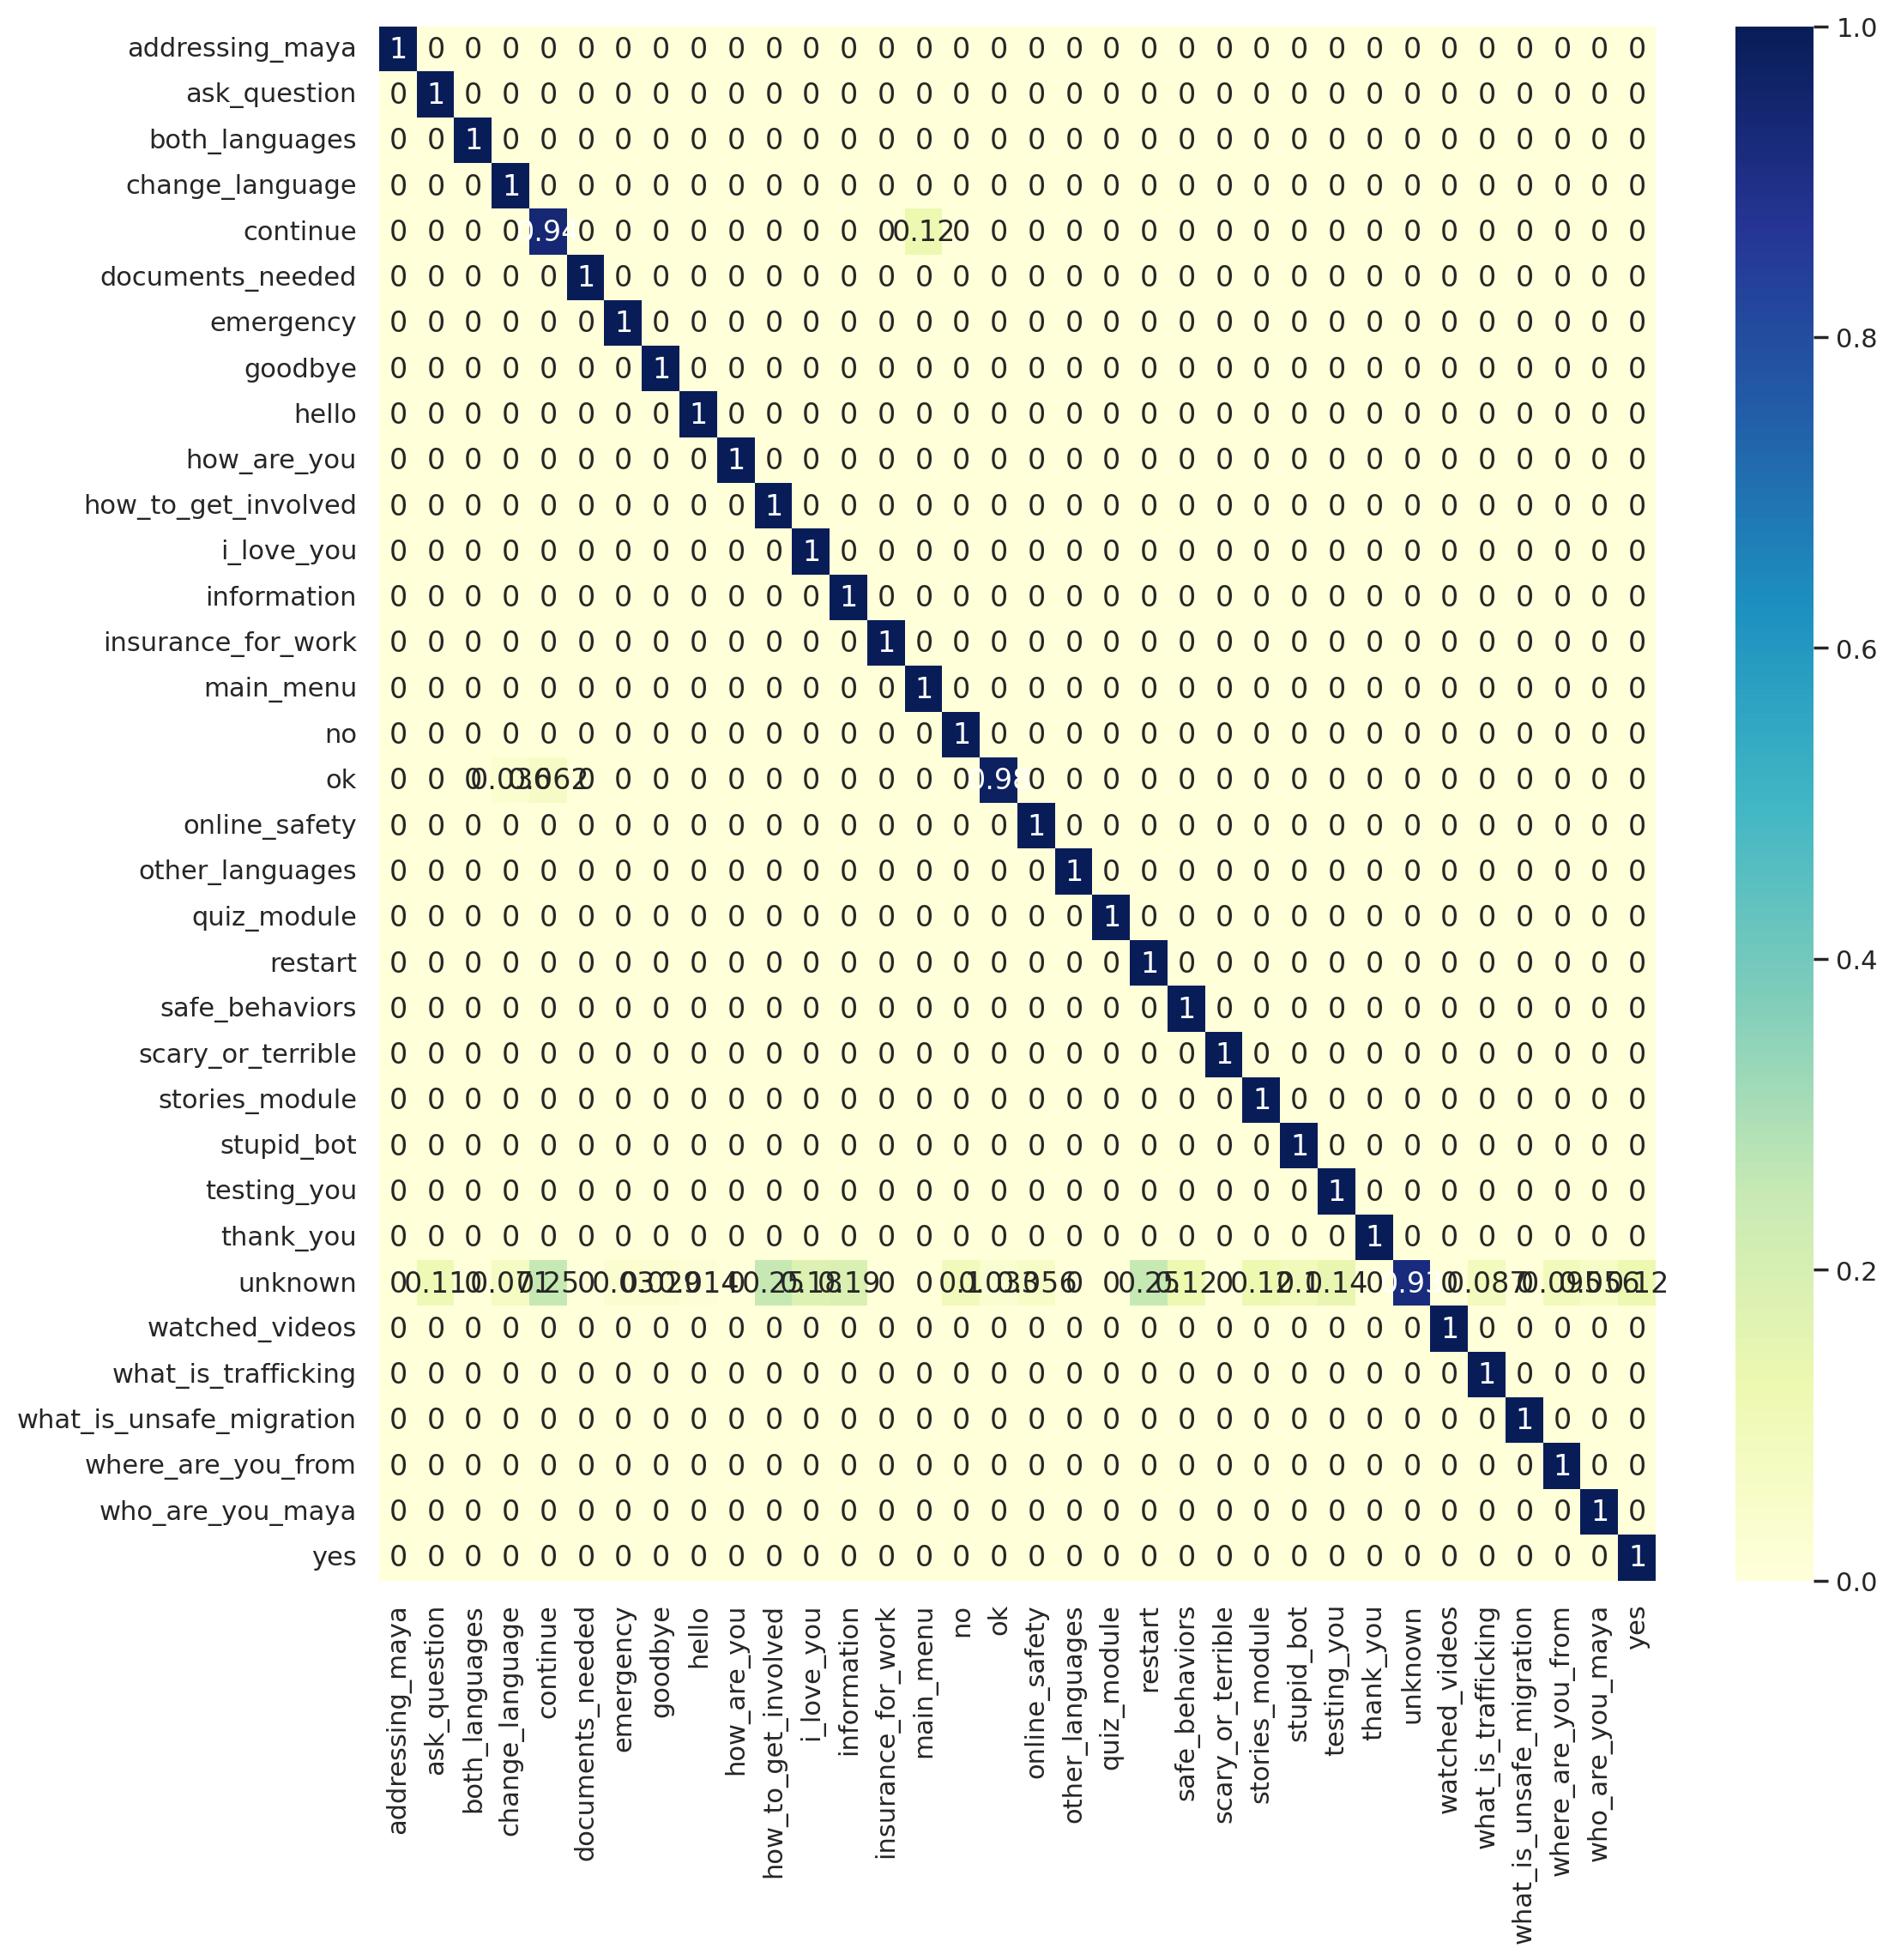

In [100]:
show_confusion(df)